In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
folder_path = "/kaggle/input/sih-dataset-2/multiclass"
all_loc = os.listdir(folder_path)
import tensorflow as tf
import tifffile

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
snippet=128
bands=['B2','B3','B4','B6','B7','B8']
x_train=np.zeros(shape=(0,snippet,snippet,len(bands)))
y_train=np.zeros(shape=(0,snippet,snippet))
# settlements={'loc1':3,'loc2':9}

def extract_snippets(image, snippet_size=(snippet, snippet)):
    snippets = []
    height=image.shape[0]
    width=image.shape[1]
    
    for i in range(0, height, snippet_size[0]):
        for j in range(0, width, snippet_size[1]):
            snippet = image[i:i+snippet_size[0], j:j+snippet_size[1],:]
            snippets.append(snippet)
    return snippets

def extract_snippets_label(image, snippet_size=(snippet, snippet)):
    snippets = []
    height=image.shape[0]
    width=image.shape[1]
    for i in range(0, height, snippet_size[0]):
        for j in range(0, width, snippet_size[1]):
            snippet = image[i:i+snippet_size[0], j:j+snippet_size[1]]
            snippets.append(snippet)
    return snippets

all_loc=['loc1','loc2','loc3','loc4','loc5']

for fold in all_loc:
    temp=folder_path+"/"+fold
    tif_files = [file for file in os.listdir(temp) if file.endswith('.tif')]
    im=np.array(Image.open(temp+"/"+tif_files[0]))
    data=np.zeros((im.shape[0],im.shape[1],len(bands)))
    i=0
    for file_name in bands:
        im = Image.open(temp+"/"+file_name+".tif")
        imarray = np.array(im)
        data[:,:,i]=imarray
        i+=1
    data=np.array(data)
#     data=data/np.max(data)
    print(data.shape)
    lab = tifffile.imread(temp+"/labels/mask.tif")
    label=np.array(lab)
#     label[label != settlements[fold]] = 0
#     label[label == settlements[fold]] = 1
    height=data.shape[0]
    width=data.shape[1]
    pad_height = (height // snippet + 1) * snippet - height
    pad_width = (width // snippet + 1) * snippet - width
    pad = np.pad(data, ((0, pad_height), (0, pad_width),(0,0)), mode='constant')
    labpad=np.pad(label, ((0, pad_height), (0, pad_width)), mode='constant')
    tmp1=np.array(extract_snippets(pad))
    tmp2=np.array(extract_snippets_label(labpad))
    x_train=np.concatenate((x_train,tmp1),axis=0)
    y_train=np.concatenate((y_train,tmp2),axis=0)
print(x_train.shape)
print(y_train.shape)

(823, 1620, 6)
(461, 443, 6)
(434, 1261, 6)
(638, 577, 6)
(350, 576, 6)
(187, 128, 128, 6)
(187, 128, 128)


In [57]:
import numpy as np
# from scio
# Assuming x_train is a NumPy array with shape (num_samples, 128, 128, 6)
# Assuming y_train is a NumPy array with shape (num_samples, 128, 128)

# Function to rotate 3D images and labels
def rotate_3D_images_and_labels(images, labels, angles=[90, 180, 270]):
    rotated_images = []
    rotated_labels = []

    for angle in angles:
        for image, label in zip(images, labels):
            rotated_image = np.stack([np.rot90(channel, k=angle // 90) for channel in np.moveaxis(image, -1, 0)], axis=-1)
            rotated_label = np.rot90(label, k=angle // 90)

            rotated_images.append(rotated_image)
            rotated_labels.append(rotated_label)

    return np.array(rotated_images), np.array(rotated_labels)

# Rotate 3D images and labels
x_train, y_train = rotate_3D_images_and_labels(x_train, y_train)



In [58]:
x_train.shape,y_train.shape

((561, 128, 128, 6), (561, 128, 128))

In [7]:

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
num_classes=6
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

#     b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(p3, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """ # Change this to the actual number of classes

    outputs = L.Conv2D(7, 1, padding="same", activation="softmax")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (128, 128,5)
    model = attention_unet(input_shape)
    model.summary()


Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 5)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         2944      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normaliza

In [8]:
y_train=y_train.astype(int)
num_classes = 7  # Number of classes (0 to 6)
y_one_hot = np.eye(num_classes)[y_train]

In [9]:
y_one_hot.shape

(561, 128, 128, 7)

In [10]:
from keras import backend as K
# def dice_coefficient(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     union = K.sum(y_true) + K.sum(y_pred)
#     return (2.0 * intersection) / (union + 1e-8)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coefficient(y_true, y_pred)
# from keras import backend as K

def dice_coefficient_multi_class(y_true, y_pred, num_classes):
    dice_coefficients = []

    for class_idx in range(num_classes):
        # Binary masks for the current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]

        # Calculate Dice coefficient for the current class
        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class)
        dice_coefficient_class = (2.0 * intersection) / (union + 1e-8)

        # Append to the list of Dice coefficients for each class
        dice_coefficients.append(dice_coefficient_class)

    # Average Dice coefficient over all classes
    average_dice_coefficient = K.mean(K.stack(dice_coefficients))

    return average_dice_coefficient

# def dice_loss(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
#     denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
#     dice_coefficient = tf.reduce_mean(numerator / denominator)
#     loss = 1 - dice_coefficient
#     return loss

def calculate_jaccard_index(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))

    jaccard_index = intersection / union if union > 0 else 0.0
    return jaccard_index


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


def focal_loss(y_true, y_pred):
    alpha=0.5
    gamma=2
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip to avoid numerical instability
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0))


input_shape=(128,128,len(bands))
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=35, monitor='val_iou_coef', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0000001, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint("best_weight.h5", verbose=1, monitor='mean_iou', mode='max', save_best_only=True, save_weights_only=False),
]
model = attention_unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train,y_one_hot,epochs=35,validation_split=0.2 , callbacks=callbacks, shuffle=True)

Epoch 1/35
14/14 [==============================] - 46s 736ms/step - loss: 1.1042 - accuracy: 0.6867 - val_loss: 334.9437 - val_accuracy: 0.3115 - lr: 0.0010
Epoch 2/35
14/14 [==============================] - 7s 472ms/step - loss: 0.6887 - accuracy: 0.7987 - val_loss: 152.9228 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 3/35
14/14 [==============================] - 7s 477ms/step - loss: 0.6183 - accuracy: 0.8109 - val_loss: 35.3438 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 4/35
14/14 [==============================] - 7s 476ms/step - loss: 0.5728 - accuracy: 0.8179 - val_loss: 17.8719 - val_accuracy: 0.3355 - lr: 0.0010
Epoch 5/35
14/14 [==============================] - 7s 481ms/step - loss: 0.5830 - accuracy: 0.8116 - val_loss: 9.9820 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 6/35
14/14 [==============================] - 7s 483ms/step - loss: 0.5500 - accuracy: 0.8195 - val_loss: 5.1463 - val_accuracy: 0.4611 - lr: 0.0010
Epoch 7/35
14/14 [==============================] - 7s 486ms/st

In [12]:
predictions=model.predict(x_train)
predictions=np.argmax(predictions,axis=-1)
plt.imshow(y_train[0])
plt.show()
plt.imshow(predictions[0])

18/18 [==============================] - 2s 140ms/step


In [13]:
predictions=np.argmax(predictions,axis=-1)

In [14]:
predictions.shape

(561, 128, 128)

In [15]:
predictions[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4]])

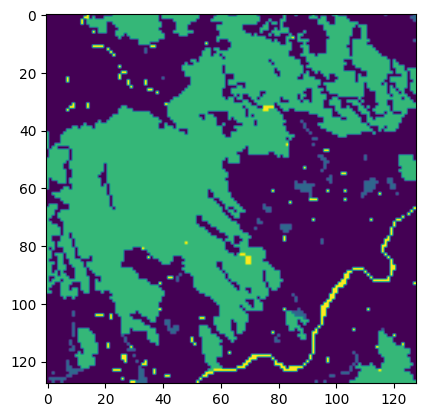

In [16]:
plt.imshow(y_train[0])

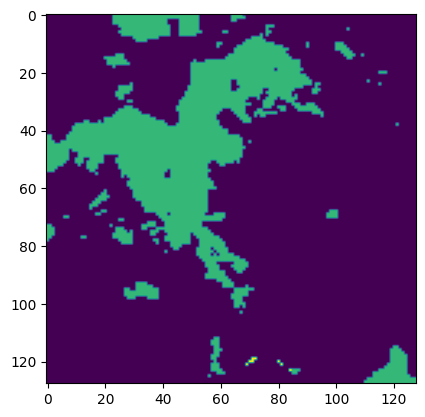

In [18]:
plt.imshow(predictions[0], cmap='viridis')

In [59]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Change the output layer for multi-class classification
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (128, 128, 6)
    num_classes = 7  # Change this to the actual number of classes
    model = build_unet(input_shape, num_classes)
    model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 6)]        0         []                            
                                                                                                  
 conv2d_177 (Conv2D)         (None, 128, 128, 64)         3520      ['input_10[0][0]']            
                                                                                                  
 batch_normalization_162 (B  (None, 128, 128, 64)         256       ['conv2d_177[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_162 (Activation  (None, 128, 128, 64)         0         ['batch_normalization_162[

In [60]:
from keras import backend as K
# def dice_coefficient(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     union = K.sum(y_true) + K.sum(y_pred)
#     return (2.0 * intersection) / (union + 1e-8)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coefficient(y_true, y_pred)
# from keras import backend as K

def dice_coefficient_multi_class(y_true, y_pred, num_classes):
    dice_coefficients = []

    for class_idx in range(num_classes):
        # Binary masks for the current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]

        # Calculate Dice coefficient for the current class
        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class)
        dice_coefficient_class = (2.0 * intersection) / (union + 1e-8)

        # Append to the list of Dice coefficients for each class
        dice_coefficients.append(dice_coefficient_class)

    # Average Dice coefficient over all classes
    average_dice_coefficient = K.mean(K.stack(dice_coefficients))

    return average_dice_coefficient

# def dice_loss(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
#     denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
#     dice_coefficient = tf.reduce_mean(numerator / denominator)
#     loss = 1 - dice_coefficient
#     return loss

def calculate_jaccard_index(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))

    jaccard_index = intersection / union if union > 0 else 0.0
    return jaccard_index


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


def focal_loss(y_true, y_pred):
    alpha=0.5
    gamma=2
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip to avoid numerical instability
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0))

num_classes=7
input_shape=(128,128,len(bands))
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=35, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0000001, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint("best_weight.h5", verbose=1, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=False),
]
model = build_unet(input_shape,num_classes)
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])
model.fit(x_train,y_one_hot,epochs=100,validation_split=0.2 , callbacks=callbacks, shuffle=True)

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.7029
Epoch 1: val_accuracy improved from -inf to 0.06265, saving model to best_weight.h5
14/14 [==============================] - 22s 617ms/step - loss: 0.1583 - accuracy: 0.7029 - val_loss: 3.7759 - val_accuracy: 0.0627 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.7998
Epoch 2: val_accuracy improved from 0.06265 to 0.09853, saving model to best_weight.h5
14/14 [==============================] - 8s 564ms/step - loss: 0.0876 - accuracy: 0.7998 - val_loss: 3.6264 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.8010
Epoch 3: val_accuracy improved from 0.09853 to 0.17210, saving model to best_weight.h5
14/14 [==============================] - 8s 565ms/step - loss: 0.0787 - accuracy: 0.8010 - val_loss: 2.9866 - val_accuracy: 0.1721 - lr: 0.0010
Epoch 4/100
14/14 [=====

18/18 [==============================] - 3s 134ms/step


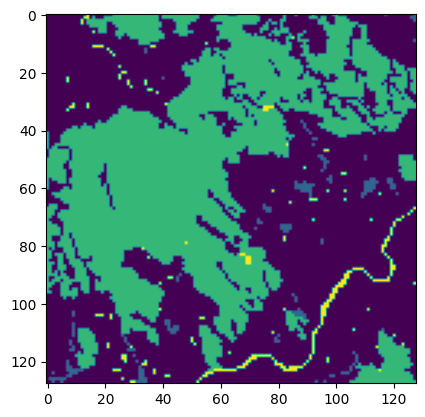

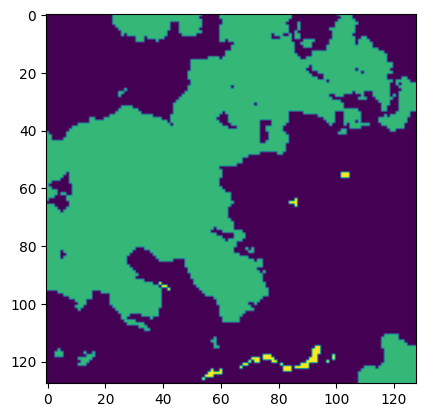

In [61]:
ans=model.predict(x_train)
ans=np.argmax(ans,axis=-1)
plt.imshow(y_train[0])
plt.show()
plt.imshow(ans[0])

['B2.tif', 'B3.tif', 'B4.tif', 'B6.tif', 'B7.tif', 'B8.tif']
(638, 577, 6)
(25, 128, 128, 6)
1/1 [==============================] - 0s 30ms/step


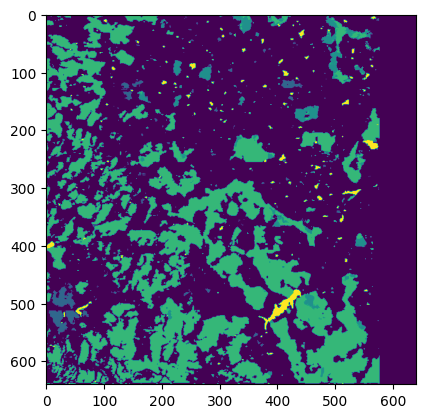

In [62]:
snippet=128
folder_path = "/kaggle/input/sih-dataset-2/multiclass"
all_loc = os.listdir(folder_path)
x_train=np.zeros(shape=(0,snippet,snippet,len(bands)))
y_train=np.zeros(shape=(0,snippet,snippet))
# settlements={'loc1':3,'loc2':9}
def extract_snippets(image, snippet_size=(snippet, snippet)):
    snippets = []
    height=image.shape[0]
    width=image.shape[1]
    
    for i in range(0, height, snippet_size[0]):
        for j in range(0, width, snippet_size[1]):
            snippet = image[i:i+snippet_size[0], j:j+snippet_size[1],:]
            snippets.append(snippet)
    return snippets
fold='loc4'
temp=folder_path+"/"+fold
tif_files = [file for file in os.listdir(temp) if file.endswith('.tif')]
tif_files=[ 'B2.tif', 'B3.tif', 'B4.tif', 'B6.tif', 'B7.tif', 'B8.tif']
print(tif_files)
im=np.array(Image.open(temp+"/"+tif_files[0]))
data=np.zeros((im.shape[0],im.shape[1],len(bands)))
i=0
for file_name in tif_files:
    im = Image.open(temp+"/"+file_name)
    imarray = np.array(im)
    data[:,:,i]=imarray
    i+=1
data=np.array(data)
# data=data/np.max(data)
print(data.shape)
# lab = Image.open(temp+"/labels/label.tif")
# label=np.array(lab)
# label[label != settlements[fold]] = 0
# label[label == settlements[fold]] = 1
height=data.shape[0]
width=data.shape[1]
pad_height = (height // snippet + 1) * snippet - height
pad_width = (width // snippet + 1) * snippet - width
pad = np.pad(data, ((0, pad_height), (0, pad_width),(0,0)), mode='constant')
# labpad=np.pad(label, ((0, pad_height), (0, pad_width)), mode='constant')
tmp1=np.array(extract_snippets(pad))
# tmp2=np.array(extract_snippets_label(labpad))
x_train=np.concatenate((x_train,tmp1),axis=0)
# y_train=np.concatenate((y_train,tmp2),axis=0)
print(x_train.shape)
# print(y_train.shape)
ans=model.predict(x_train)
ans=np.argmax(ans,axis=-1)
ans=ans.reshape(-1,128,128)
output=np.zeros(shape=(pad.shape[0],pad.shape[1]))
ans.shape
height,width=pad.shape[0:2]
k=height//128
l=width//128
for i in range(0, height, 128):
    for j in range(0, width, 128):
        output[i:i+128, j:j+128]=ans[(i*l)//(128)+(j//128)]
# result = (output > 0.9).astype(int)
plt.imshow(output)

In [44]:
print(output)

[[ 28. 107.  87. ...  32.   5.  70.]
 [ 28. 107.  87. ...  32.   5.  70.]
 [ 28. 107.  87. ...  32.   5.  70.]
 ...
 [  4.  93.  35. ...  81.  62.  77.]
 [  4.  93.  35. ...  81.  62.  77.]
 [  4.  93.  35. ...  81.  62.  77.]]


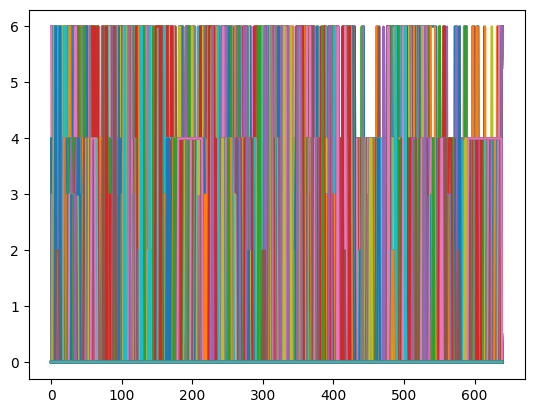

In [23]:
import tifffile
before=tifffile.imread("/kaggle/input/sih-dataset-2/multiclass/loc1/labels/mask.tif")
after=tifffile.imread("/kaggle/input/xyzzy-sih/output1-3.tif")
before.shape,after.shape
# plt.plot(before)
after=np.array(after)
plt.plot(after)

In [63]:
# img = tifffile.imread(result)

# Save the image as a TIFF file
tifffile.imsave("output1.tif", output)

/tmp/ipykernel_42/2900324738.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("output1.tif", output)


Image Similarity: 91.9886%


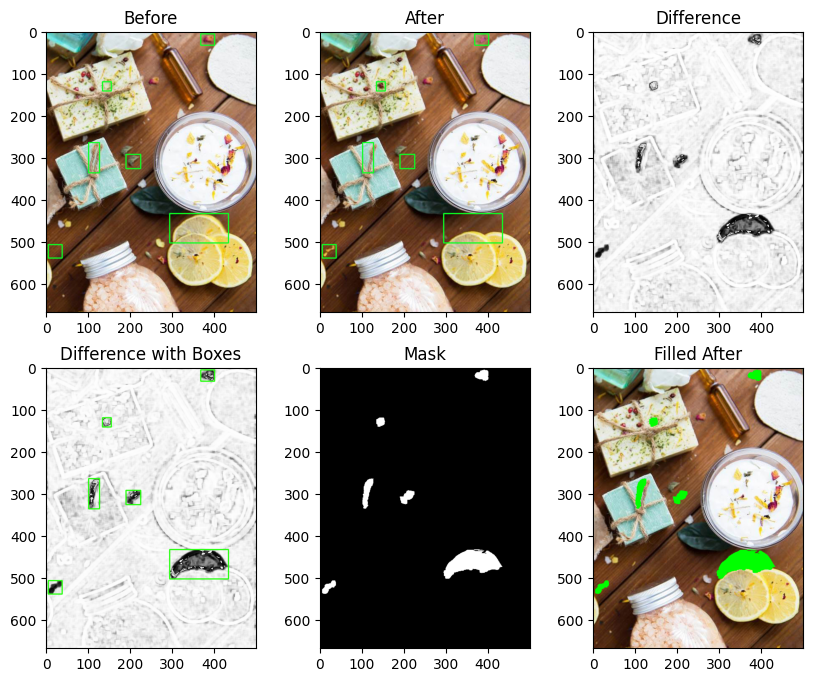

In [25]:
# # from skimage.metrics import structural_similarity
# # import cv2
# # import numpy as np


# # # Convert images to grayscale
# # before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
# # after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# # # Compute SSIM between the two images
# # (score, diff) = structural_similarity(before_gray, after_gray, full=True)
# # print("Image Similarity: {:.4f}%".format(score * 100))

# # # The diff image contains the actual image differences between the two images
# # # and is represented as a floating point data type in the range [0,1] 
# # # so we must convert the array to 8-bit unsigned integers in the range
# # # [0,255] before we can use it with OpenCV
# # diff = (diff * 255).astype("uint8")
# # diff_box = cv2.merge([diff, diff, diff])

# # # Threshold the difference image, followed by finding contours to
# # # obtain the regions of the two input images that differ
# # thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# # contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# # contours = contours[0] if len(contours) == 2 else contours[1]

# # mask = np.zeros(before.shape, dtype='uint8')
# # filled_after = after.copy()
# # for c in contours:
# #     area = cv2.contourArea(c)
# #     if area > 40:
# #         x,y,w,h = cv2.boundingRect(c)
# #         cv2.rectangle(before, (x, y), (x + w, y + h), (36,255,12), 2)
# #         cv2.rectangle(after, (x, y), (x + w, y + h), (36,255,12), 2)
# #         cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36,255,12), 2)
# #         cv2.drawContours(mask, [c], 0, (255,255,255), -1)
# #         cv2.drawContours(filled_after, [c], 0, (0,255,0), -1)

# # cv2.imshow('before', before)
# # cv2.imshow('after', after)
# # cv2.imshow('diff', diff)
# # cv2.imshow('diff_box', diff_box)
# # cv2.imshow('mask', mask)
# # cv2.imshow('filled after', filled_after)
# # cv2.waitKey()

# from skimage.metrics import structural_similarity
# import cv2
# import numpy as np

# # Read TIFF images
# before = cv2.imread("/kaggle/input/zsdcdcxcz/before.jpeg")
# after = cv2.imread("/kaggle/input/zsdcdcxcz/after.jpeg")

# # Convert images to grayscale
# before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
# after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# # Compute SSIM between the two images
# (score, diff) = structural_similarity(before_gray, after_gray, full=True)
# print("Image Similarity: {:.4f}%".format(score * 100))

# # The diff image contains the actual image differences between the two images
# # and is represented as a floating point data type in the range [0,1] 
# # so we must convert the array to 8-bit unsigned integers in the range
# # [0,255] before we can use it with OpenCV
# diff = (diff * 255).astype("uint8")
# diff_box = cv2.merge([diff, diff, diff])

# # Threshold the difference image, followed by finding contours to
# # obtain the regions of the two input images that differ
# thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# mask = np.zeros(before.shape, dtype='uint8')
# filled_after = after.copy()
# for c in contours:
#     area = cv2.contourArea(c)
#     if area > 40:
#         x, y, w, h = cv2.boundingRect(c)
#         cv2.rectangle(before, (x, y), (x + w, y + h), (36, 255, 12), 2)
#         cv2.rectangle(after, (x, y), (x + w, y + h), (36, 255, 12), 2)
#         cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36, 255, 12), 2)
#         cv2.drawContours(mask, [c], 0, (255, 255, 255), -1)
#         cv2.drawContours(filled_after, [c], 0, (0, 255, 0), -1)

# cv2.imshow('before', before)
# cv2.imshow('after', after)
# cv2.imshow('diff', diff)
# cv2.imshow('diff_box', diff_box)
# cv2.imshow('mask', mask)
# cv2.imshow('filled after', filled_after)
# cv2.waitKey()
from skimage.metrics import structural_similarity
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read TIFF images
before = cv2.imread('/kaggle/input/zsdcdcxcz/before.jpeg')
after = cv2.imread('/kaggle/input/zsdcdcxcz/after.jpeg')

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between the two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1] 
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")
diff_box = cv2.merge([diff, diff, diff])

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros(before.shape, dtype='uint8')
filled_after = after.copy()
for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.drawContours(mask, [c], 0, (255, 255, 255), -1)
        cv2.drawContours(filled_after, [c], 0, (0, 255, 0), -1)

# Display images using matplotlib
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
plt.title('Before')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
plt.title('After')

plt.subplot(2, 3, 3)
plt.imshow(diff, cmap='gray')
plt.title('Difference')

plt.subplot(2, 3, 4)
plt.imshow(diff_box)
plt.title('Difference with Boxes')

plt.subplot(2, 3, 5)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(filled_after, cv2.COLOR_BGR2RGB))
plt.title('Filled After')

plt.show()


In [16]:
print(before)
before.shape,after.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [2. 2. 0. ... 0. 0. 0.]
 ...
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]]


((823, 1620), (640, 640))